# Pivot for logistic regression on queue imbalance feature

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stocks = list(roc_results.result_test_10000.keys())

In [3]:
def get_pivot(log_clf, df, s, label='train'):
    pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
    df['pred_log'] = pred
    roc_score = roc_auc_score(df['mid_price_indicator'], pred)
    pivot = min(df[df['pred_log'] == 1]['queue_imbalance'])
    positives_below_pivot = len(df[df['queue_imbalance'] < pivot][df['pred_log'] == 1])
    negatives_above_pivot = len(df[df['queue_imbalance'] >= pivot][df['pred_log'] == 0])
    len_below_pivot = len(df[df['queue_imbalance'] < pivot]) 
    len_above_pivot = len(df[df['queue_imbalance'] >= pivot])
    return {
        'stock': s,
        'label': label,
        'pivot': pivot,
        'roc_score': roc_score,
        'positives_below_pivot': positives_below_pivot,
        'negatives_above_pivot': negatives_above_pivot,
        'len_below_pivot': len_below_pivot,
        'len_above_pivot': len_above_pivot,
        'coef_': log_clf.coef_[0][0],
        'intercept_': log_clf.intercept_[0]
    }

In [16]:
pivots = []
for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(
        s, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)
    log_clf = lob.logistic_regression(df, 0, len(df))
    pivots.append(get_pivot(log_clf, df, s, label='train'))
    pivots.append(get_pivot(log_clf, df_test, s, label='test'))
df_pivots = pd.DataFrame(pivots)

In [17]:
print(len(df_pivots[df_pivots['positives_below_pivot'] > 0]))
print(len(df_pivots[df_pivots['negatives_above_pivot'] > 0]))

0
0


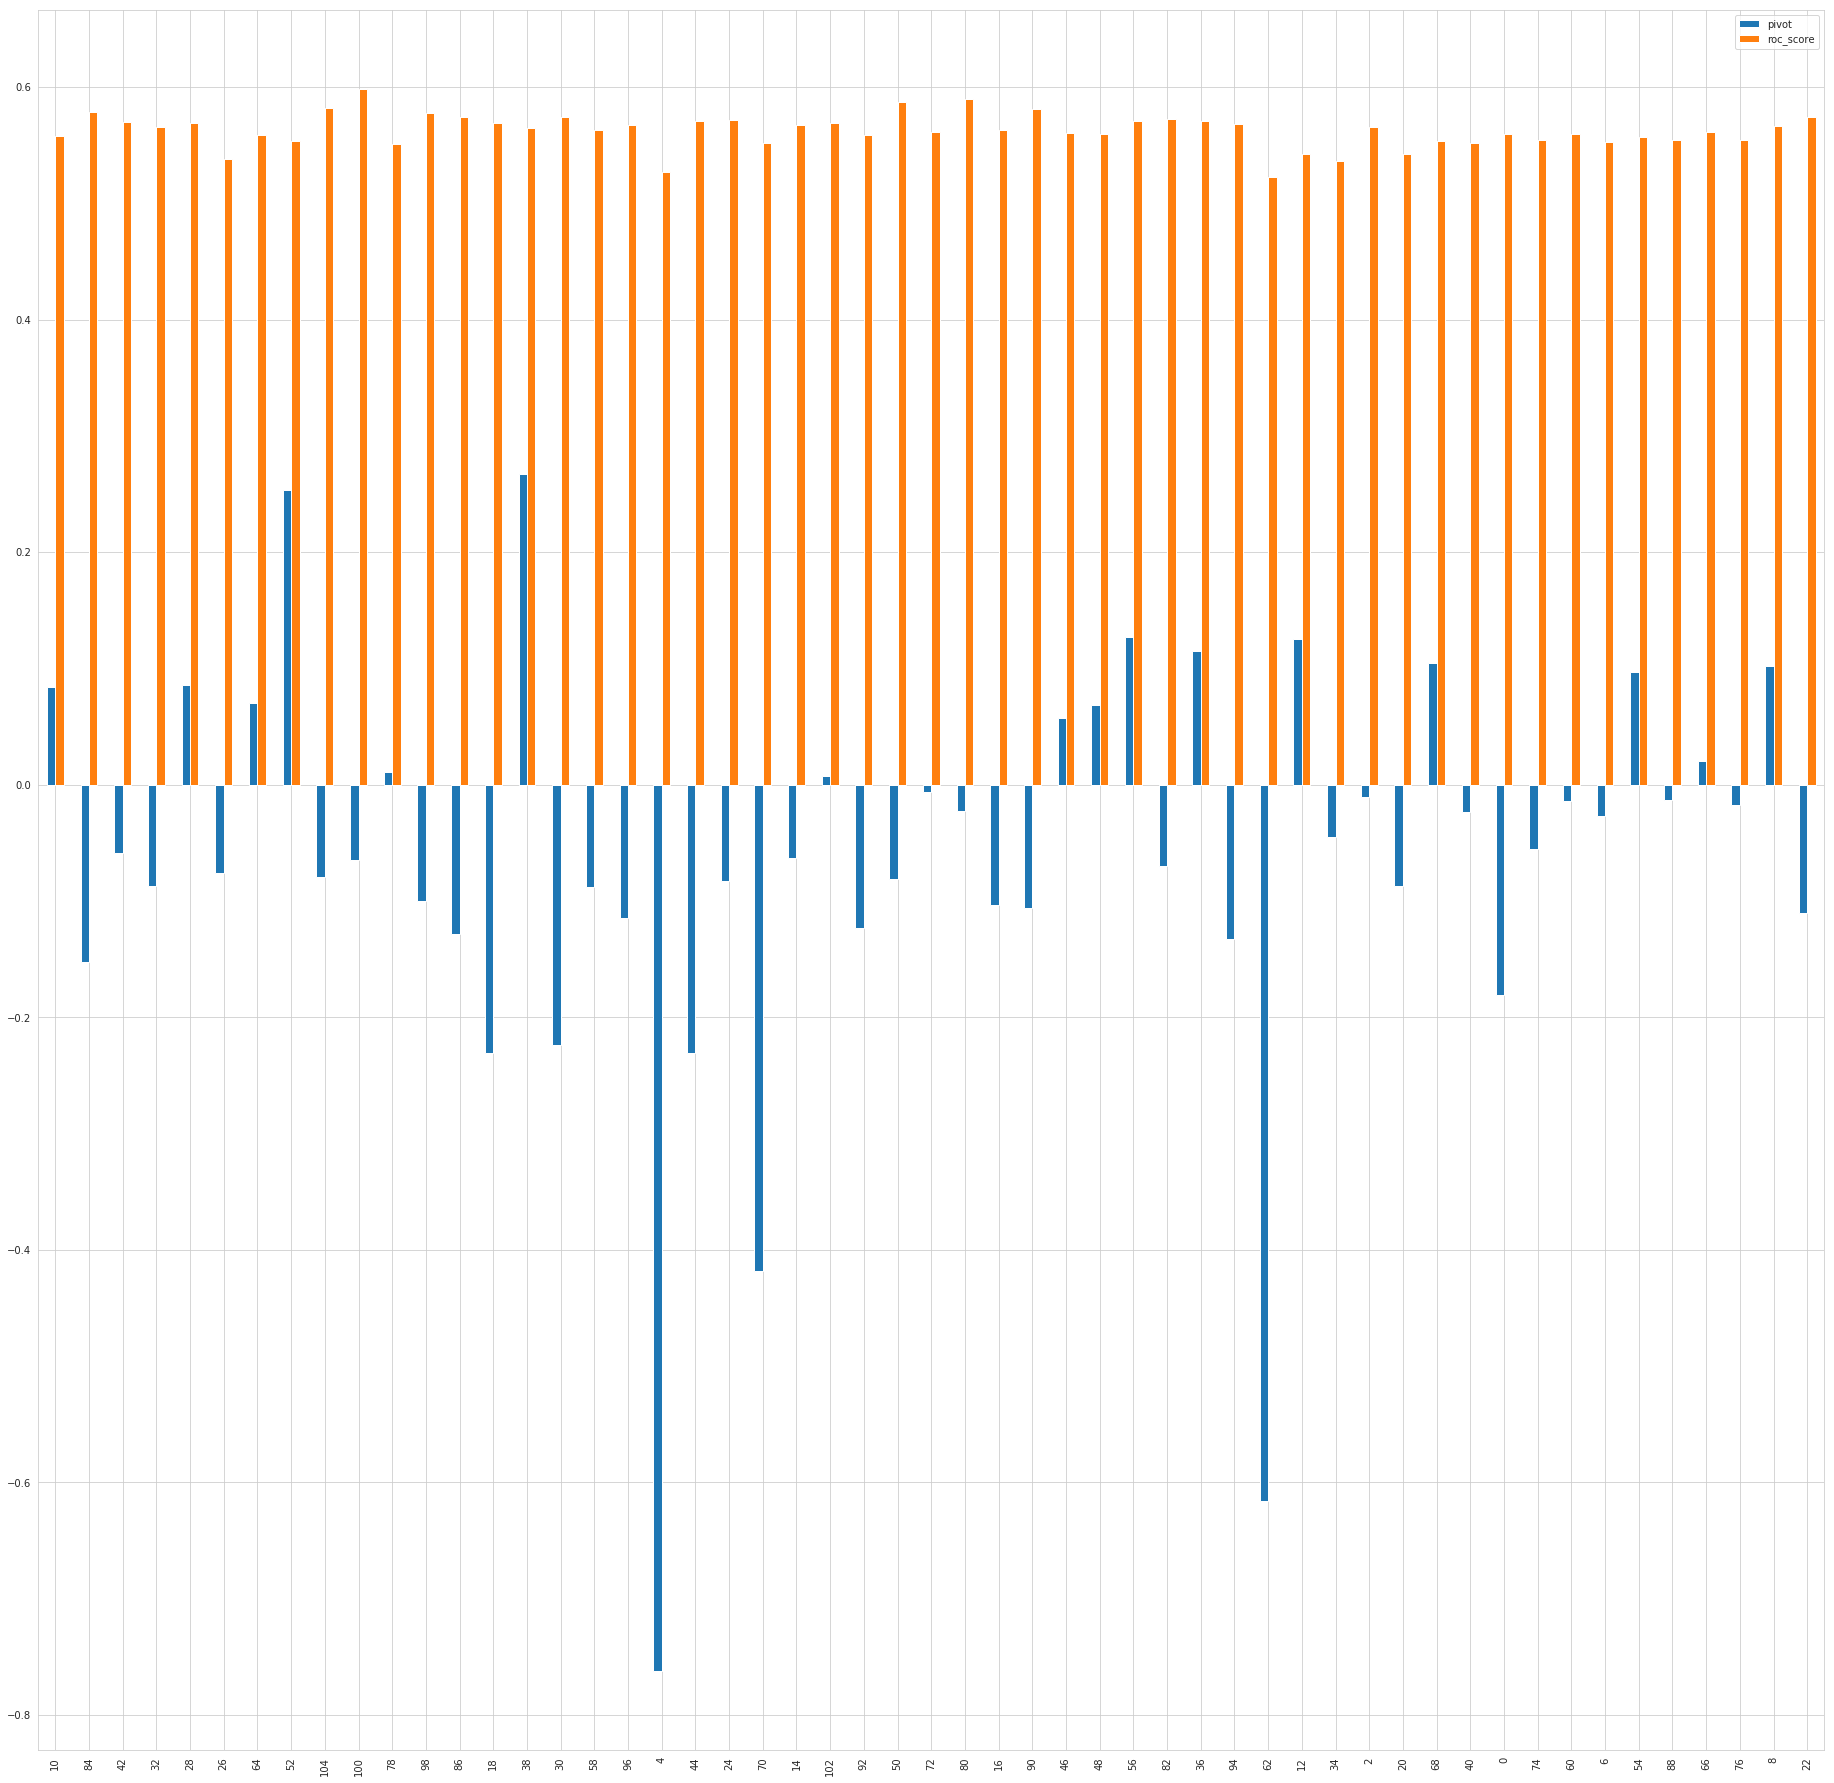

In [30]:
df_pivots['ratio'] = df_pivots['len_above_pivot'] / df_pivots['len_below_pivot']
df_pivots.sort_values(by='stock')[df_pivots['label'] == 'train'][['pivot', 'roc_score']].plot(
    kind='bar',figsize=(32, 32))

In [19]:
df_pivots.describe()

,coef_,intercept_,len_above_pivot,len_below_pivot,negatives_above_pivot,pivot,positives_below_pivot,roc_score,ratio
count,106.000000,106.000000,106.000000,106.000000,106.0,106.000000,106.0,106.000000,106.000000
mean,0.436775,0.021367,2172.896226,1827.103774,0.0,-0.060341,0.0,0.559388,1.495220
std,0.152815,0.062395,1165.952134,1015.056460,0.0,0.173026,0.0,0.015813,1.736519
min,0.082433,-0.152154,541.000000,126.000000,0.0,-0.762210,0.0,0.511466,0.370802
25%,0.367899,-0.008811,1074.250000,915.250000,0.0,-0.106063,0.0,0.551830,0.943166
50%,0.440563,0.017177,2126.500000,1260.500000,0.0,-0.058035,0.0,0.560052,1.135611
75%,0.520692,0.052456,3189.000000,2809.750000,0.0,0.020896,0.0,0.569255,1.385704
max,0.853637,0.215752,5453.000000,3621.000000,0.0,0.267393,0.0,0.599317,14.873016


In [ ]:
# TODO: explore probabilities